# Análisis exploratorio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
from pathlib import Path
CSV = Path("../../data/by_game/carrusel.csv")
df = pd.read_csv(CSV)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 87 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          612 non-null    object 
 1   9:00 ciclos                   612 non-null    int64  
 2   9:00 asistencia               612 non-null    int64  
 3   10:00 ciclos                  612 non-null    int64  
 4   10:00 asistencia              612 non-null    int64  
 5   11:00 ciclos                  612 non-null    int64  
 6   11:00 asistencia              612 non-null    int64  
 7   12:00 ciclos                  612 non-null    int64  
 8   12:00 asistencia              612 non-null    int64  
 9   13:00 ciclos                  612 non-null    int64  
 10  13:00 asistencia              612 non-null    int64  
 11  14:00 ciclos                  612 non-null    int64  
 12  14:00 asistencia              612 non-null    int64  
 13  15:00

### Datos faltantes

In [4]:
na = df.isna().mean().sort_values(ascending=False)
display(na.head(20))

date                  0.0
Wq_12:00(min)         0.0
mu_14:00(/min)        0.0
lambda_14:00(/min)    0.0
state_13:00           0.0
Wq_13:00(min)         0.0
rho_13:00             0.0
mu_13:00(/min)        0.0
lambda_13:00(/min)    0.0
state_12:00           0.0
rho_12:00             0.0
Wq_14:00(min)         0.0
mu_12:00(/min)        0.0
lambda_12:00(/min)    0.0
state_11:00           0.0
Wq_11:00(min)         0.0
rho_11:00             0.0
mu_11:00(/min)        0.0
lambda_11:00(/min)    0.0
state_10:00           0.0
dtype: float64

## EDA visual

### Asistencia total por año

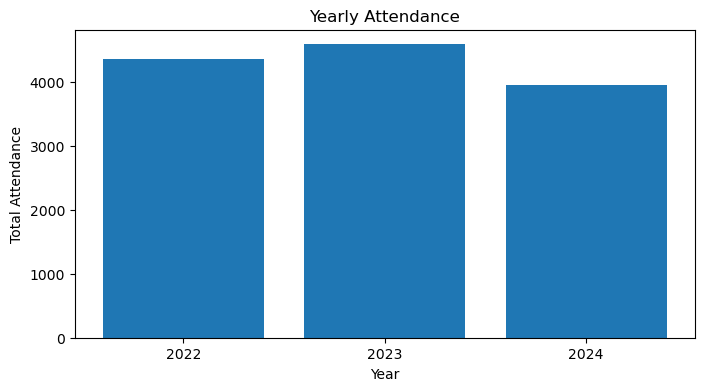

In [5]:
plt.figure(figsize=(8,4))
plt.bar(df["year"].astype(str), df["asistencia total"])
plt.title("Yearly Attendance")
plt.xlabel("Year")
plt.ylabel("Total Attendance")
plt.show()


### Asistencia por día de la semana

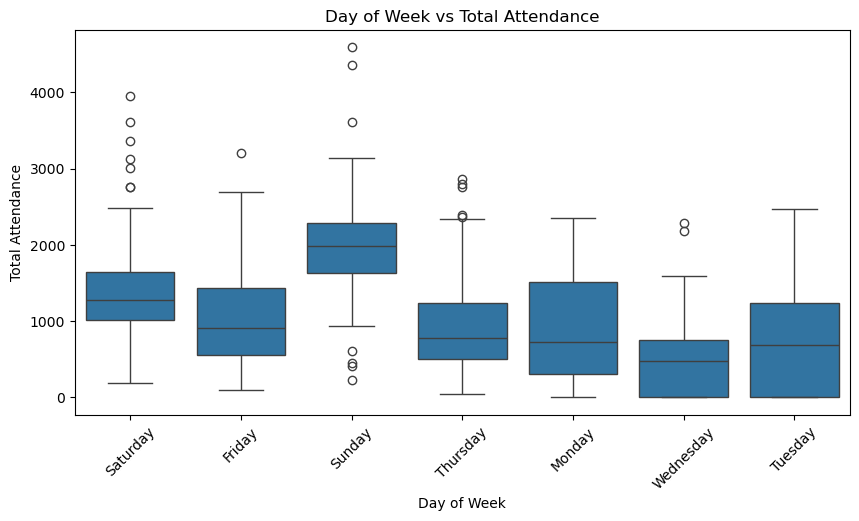

In [6]:
if {"day_of_week","asistencia total"}.issubset(df.columns):
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df, x="day_of_week", y="asistencia total")
    plt.xlabel("Day of Week")
    plt.ylabel("Total Attendance")
    plt.title("Day of Week vs Total Attendance")
    plt.xticks(rotation=45)
    plt.show()

### Matriz de correlación

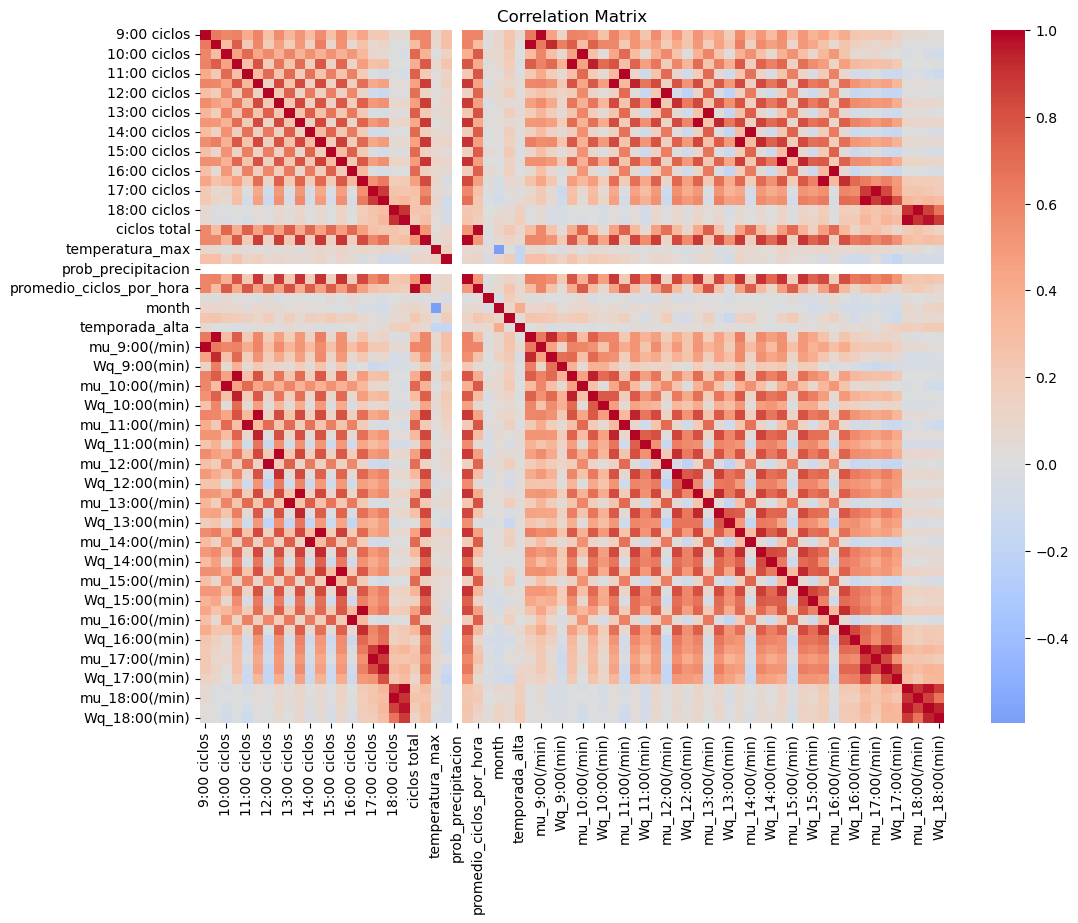

In [7]:
num = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12,9))
sns.heatmap(num.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

### Limpieza de datos

In [8]:

# Columnas a mantener
horas = [f"{h}:00" for h in range(9, 19)]

base_keep = [c for c in [
    "date", "day_of_week", "es_festivo", "nombre_festivo",
    "temperatura_max", "condiciones_cielo", "temporada_alta",
] if c in df.columns]

wq_cols     = [c for c in df.columns if c.startswith("Wq_") and "(min)" in c]
state_cols  = [c for c in df.columns if c.startswith("state_")]
asis_h_cols = [f"{h} asistencia" for h in horas if f"{h} asistencia" in df.columns]
cic_h_cols  = [f"{h} ciclos"     for h in horas if f"{h} ciclos"     in df.columns]
hourly_keep = [c for c in df.columns if c.endswith("asistencia") or c.endswith("ciclos")]

# Columnas finales a mantener (sin duplicados)
keep_cols = list(dict.fromkeys(base_keep + wq_cols + state_cols + hourly_keep))

In [9]:

# Columnas a eliminar
drop_patterns = ("lambda_", "mu_", "rho_", "promedio_")

drop_by_pattern = [c for c in df.columns if c.startswith(drop_patterns)]
drop_the_rest = [c for c in df.columns if c not in keep_cols and c not in drop_by_pattern]

cols_to_drop = drop_by_pattern + drop_the_rest

# Eliminar columnas
df_final = df.drop(columns=cols_to_drop)

In [10]:
print(f"Originales: {len(df.columns)}")
print(f"Mantener: {len(df_final.columns)} -> {sorted(df_final.columns)[:29]} ...")
print(f"Eliminar:  {len(cols_to_drop)}")

Originales: 87
Mantener: 47 -> ['10:00 asistencia', '10:00 ciclos', '11:00 asistencia', '11:00 ciclos', '12:00 asistencia', '12:00 ciclos', '13:00 asistencia', '13:00 ciclos', '14:00 asistencia', '14:00 ciclos', '15:00 asistencia', '15:00 ciclos', '16:00 asistencia', '16:00 ciclos', '17:00 asistencia', '17:00 ciclos', '18:00 asistencia', '18:00 ciclos', '9:00 asistencia', '9:00 ciclos', 'Wq_10:00(min)', 'Wq_11:00(min)', 'Wq_12:00(min)', 'Wq_13:00(min)', 'Wq_14:00(min)', 'Wq_15:00(min)', 'Wq_16:00(min)', 'Wq_17:00(min)', 'Wq_18:00(min)'] ...
Eliminar:  40


In [11]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               612 non-null    object 
 1   9:00 ciclos        612 non-null    int64  
 2   9:00 asistencia    612 non-null    int64  
 3   10:00 ciclos       612 non-null    int64  
 4   10:00 asistencia   612 non-null    int64  
 5   11:00 ciclos       612 non-null    int64  
 6   11:00 asistencia   612 non-null    int64  
 7   12:00 ciclos       612 non-null    int64  
 8   12:00 asistencia   612 non-null    int64  
 9   13:00 ciclos       612 non-null    int64  
 10  13:00 asistencia   612 non-null    int64  
 11  14:00 ciclos       612 non-null    int64  
 12  14:00 asistencia   612 non-null    int64  
 13  15:00 ciclos       612 non-null    float64
 14  15:00 asistencia   612 non-null    float64
 15  16:00 ciclos       612 non-null    float64
 16  16:00 asistencia   612 non

In [12]:
# ============================================
# Reformateo a formato largo 
# ============================================

# --- Configuración ---
USAR_ASISTENCIA_POR_HORA = True   
HORAS = [f"{h}:00" for h in range(9, 19)]  # 9:00..18:00

# Poner fecha en formato datetime y extraer año/mes/día
df_final = df_final.copy()
df_final["date"] = pd.to_datetime(df_final["date"], errors="coerce")
df_final["year"]  = df_final["date"].dt.year
df_final["month"] = df_final["date"].dt.month
df_final["day"]   = df_final["date"].dt.day

base_cols = [c for c in [
     "date", "day_of_week", "es_festivo", "nombre_festivo",
    "temperatura_max", "condiciones_cielo", "temporada_alta",
    "year","month","day"
] if c in df_final.columns]

# --- Construcción del DF largo ---
registros = []

def col_exists(df, col): 
    return col in df.columns

def col_h(df, h, sufijo): 
    cand = f"{h} {sufijo}"
    return cand if col_exists(df, cand) else None

for h in HORAS:
    wq_col = f"Wq_{h}(min)"
    if not col_exists(df_final, wq_col):
        continue  # si no existe Wq de esta hora, se salta

    # Subset con columnas base
    sub = df_final[base_cols].copy()
    sub["hora"] = h

    # Variables por hora (opcional)
    if USAR_ASISTENCIA_POR_HORA:
        asis_h = col_h(df_final, h, "asistencia")
        cic_h  = col_h(df_final, h, "ciclos")
        if asis_h: sub["asistencia_h"] = df_final[asis_h]
        if cic_h:  sub["ciclos_h"]     = df_final[cic_h]

    # Estado por hora (para filtrar cierres luego)
    state_h = f"state_{h}"
    sub["state"] = df_final[state_h] if col_exists(df_final, state_h) else np.nan

    # Objetivo
    sub["Wq"] = df_final[wq_col]

    registros.append(sub)

# Concatenar todo
df_final = pd.concat(registros, ignore_index=True)

# Tipos/categóricas útiles
for c in ["day_of_week","condiciones_cielo","nombre_festivo","hora","state"]:
    if c in df_final.columns:
        df_final[c] = df_final[c].astype("category")

print("Shape df_final:", df_final.shape)
print("Columnas:", list(df_final.columns))
df_final.head()

Shape df_final: (6120, 15)
Columnas: ['date', 'day_of_week', 'es_festivo', 'nombre_festivo', 'temperatura_max', 'condiciones_cielo', 'temporada_alta', 'year', 'month', 'day', 'hora', 'asistencia_h', 'ciclos_h', 'state', 'Wq']


,date,day_of_week,es_festivo,nombre_festivo,temperatura_max,condiciones_cielo,temporada_alta,year,month,day,hora,asistencia_h,ciclos_h,state,Wq
0,2022-01-01,Saturday,True,Año Nuevo,26.0,Patchy rain possible,0,2022,1,1,9:00,0.0,0.0,Closed,0.000000
1,2022-04-01,Friday,False,Ninguno,28.0,Overcast,1,2022,4,1,9:00,0.0,0.0,Closed,0.000000
2,2022-05-01,Sunday,True,Día del Trabajo,28.0,Patchy rain possible,0,2022,5,1,9:00,79.0,6.0,stable,0.331921
3,2022-07-01,Friday,False,Ninguno,25.0,Patchy rain possible,0,2022,7,1,9:00,130.0,10.0,stable,0.194381
4,2022-09-01,Thursday,False,Ninguno,22.0,Moderate or heavy rain shower,0,2022,9,1,9:00,4.0,2.0,stable,0.085175


In [13]:
FILTRAR_CERRADOS = True   
ELIMINAR_WQ_CERO = True

# Filtrar horas cerradas (state = Closed)
if FILTRAR_CERRADOS and "state" in df_final.columns:
    mask_closed = df_final["state"].astype(str).str.lower().str.contains("closed", na=False)
    print("Filas con estado cerrado:", int(mask_closed.sum()))
    df_final = df_final[~mask_closed].copy()

# Eliminar Wq <= 0 
if ELIMINAR_WQ_CERO:
    zeros = int((df_final["Wq"] <= 0).sum())
    print("Filas con Wq <= 0:", zeros)
    df_final = df_final[df_final["Wq"] > 0].copy()

if "state" in df_final.columns:
    df_final = df_final.drop(columns=["state"])

print("Shape después de limpieza:", df_final.shape)
df_final = df_final.sort_values(["date", "hora"])
df_final.head(40)


Filas con estado cerrado: 1296
Filas con Wq <= 0: 0
Shape después de limpieza: (4824, 14)


,date,day_of_week,es_festivo,nombre_festivo,temperatura_max,condiciones_cielo,temporada_alta,year,month,day,hora,asistencia_h,ciclos_h,Wq
612,2022-01-01,Saturday,True,Año Nuevo,26.0,Patchy rain possible,0,2022,1,1,10:00,120.0,8.0,0.325000
1224,2022-01-01,Saturday,True,Año Nuevo,26.0,Patchy rain possible,0,2022,1,1,11:00,132.0,7.0,0.673888
1836,2022-01-01,Saturday,True,Año Nuevo,26.0,Patchy rain possible,0,2022,1,1,12:00,152.0,5.0,60.000000
2448,2022-01-01,Saturday,True,Año Nuevo,26.0,Patchy rain possible,0,2022,1,1,13:00,240.0,6.0,60.000000
3060,2022-01-01,Saturday,True,Año Nuevo,26.0,Patchy rain possible,0,2022,1,1,14:00,210.0,6.0,60.000000
3672,2022-01-01,Saturday,True,Año Nuevo,26.0,Patchy rain possible,0,2022,1,1,15:00,180.0,5.0,60.000000
4284,2022-01-01,Saturday,True,Año Nuevo,26.0,Patchy rain possible,0,2022,1,1,16:00,200.0,5.0,60.000000
4896,2022-01-01,Saturday,True,Año Nuevo,26.0,Patchy rain possible,0,2022,1,1,17:00,200.0,6.0,60.000000
619,2022-01-02,Sunday,False,Ninguno,27.0,Patchy rain possible,0,2022,1,2,10:00,126.0,6.0,1.161546
1231,2022-01-02,Sunday,False,Ninguno,27.0,Patchy rain possible,0,2022,1,2,11:00,200.0,6.0,60.000000


In [14]:
cat_cols = [c for c in ["day_of_week","hora","es_festivo", "condiciones_cielo", "nombre_festivo"]
            if c in df_final.columns]

num_cols = [c for c in ["month","day","temperatura_max", "temporada_alta", "asistencia_h", "ciclos_h"]
            if c in df_final.columns]

features = cat_cols + num_cols
X_all = df_final[features].copy()
y_all = df_final["Wq"].astype(float)


print("Features categóricas:", cat_cols)
print("Features numéricas:", num_cols)
print("X shape:", X_all.shape, "| y shape:", y_all.shape)


Features categóricas: ['day_of_week', 'hora', 'es_festivo', 'condiciones_cielo', 'nombre_festivo']
Features numéricas: ['month', 'day', 'temperatura_max', 'temporada_alta', 'asistencia_h', 'ciclos_h']
X shape: (4824, 11) | y shape: (4824,)


In [15]:
X_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4824 entries, 612 to 607
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   day_of_week        4824 non-null   category
 1   hora               4824 non-null   category
 2   es_festivo         4824 non-null   bool    
 3   condiciones_cielo  4824 non-null   category
 4   nombre_festivo     4824 non-null   category
 5   month              4824 non-null   int32   
 6   day                4824 non-null   int32   
 7   temperatura_max    4824 non-null   float64 
 8   temporada_alta     4824 non-null   int64   
 9   asistencia_h       4824 non-null   float64 
 10  ciclos_h           4824 non-null   float64 
dtypes: bool(1), category(4), float64(3), int32(2), int64(1)
memory usage: 251.1 KB


In [16]:
X_all.head(10)

,day_of_week,hora,es_festivo,condiciones_cielo,nombre_festivo,month,day,temperatura_max,temporada_alta,asistencia_h,ciclos_h
612,Saturday,10:00,True,Patchy rain possible,Año Nuevo,1,1,26.0,0,120.0,8.0
1224,Saturday,11:00,True,Patchy rain possible,Año Nuevo,1,1,26.0,0,132.0,7.0
1836,Saturday,12:00,True,Patchy rain possible,Año Nuevo,1,1,26.0,0,152.0,5.0
2448,Saturday,13:00,True,Patchy rain possible,Año Nuevo,1,1,26.0,0,240.0,6.0
3060,Saturday,14:00,True,Patchy rain possible,Año Nuevo,1,1,26.0,0,210.0,6.0
3672,Saturday,15:00,True,Patchy rain possible,Año Nuevo,1,1,26.0,0,180.0,5.0
4284,Saturday,16:00,True,Patchy rain possible,Año Nuevo,1,1,26.0,0,200.0,5.0
4896,Saturday,17:00,True,Patchy rain possible,Año Nuevo,1,1,26.0,0,200.0,6.0
619,Sunday,10:00,False,Patchy rain possible,Ninguno,1,2,27.0,0,126.0,6.0
1231,Sunday,11:00,False,Patchy rain possible,Ninguno,1,2,27.0,0,200.0,6.0


In [17]:
# Ver porcentaje de outliers usando método IQR
Q1 = y_all.quantile(0.25)
Q3 = y_all.quantile(0.75)
IQR = Q3 - Q1
umbral_inferior = Q1 - 1.5 * IQR
umbral_superior = Q3 + 1.5 * IQR

# Identificar outliers
outliers_mask = (y_all < umbral_inferior) | (y_all > umbral_superior)
num_outliers = outliers_mask.sum()
porcentaje_outliers = (num_outliers / len(y_all)) * 100

print(f"Total de datos: {len(y_all)}")
print(f"Q1: {Q1:.4f}, Q3: {Q3:.4f}, IQR: {IQR:.4f}")
print(f"Rango normal: [{umbral_inferior:.4f}, {umbral_superior:.4f}]")
print(f"Outliers encontrados: {num_outliers} ({porcentaje_outliers:.2f}%)")

print("Valores atípicos en y_all:")
print(y_all[outliers_mask])

# Eliminar outliers
if porcentaje_outliers < 5:  # Solo eliminar si es menos del 5%
    X_clean = X_all[~outliers_mask]
    y_clean = y_all[~outliers_mask]
else:
    X_clean = X_all.copy()
    y_clean = y_all.copy()
    print("No se eliminaron outliers debido a su alto porcentaje.")

Total de datos: 4824
Q1: 0.1049, Q3: 2.3216, IQR: 2.2166
Rango normal: [-3.2200, 5.6465]
Outliers encontrados: 1063 (22.04%)
Valores atípicos en y_all:
1836    60.0
2448    60.0
3060    60.0
3672    60.0
4284    60.0
        ... 
1825    60.0
3661    60.0
4273    60.0
4885    60.0
5497    60.0
Name: Wq, Length: 1063, dtype: float64
No se eliminaron outliers debido a su alto porcentaje.


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline as SkPipeline

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=RANDOM_STATE)


In [19]:
from sklearn.impute import SimpleImputer

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop=None), cat_cols),
        ("num", SkPipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            # no scaler, RF no lo necesita
        ]), num_cols),
    ],
    remainder="drop"
)

rf = RandomForestRegressor(
    n_estimators=600, max_depth=None, min_samples_leaf=2, min_samples_split=4,
    max_features="sqrt", n_jobs=-1, random_state=RANDOM_STATE, bootstrap=True
)

pipe = Pipeline(steps=[("pre", pre), ("model", rf)])


In [20]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

def report(y_true, y_pred, name="modelo"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}] MAE={mae:,.2f} | RMSE={rmse:,.2f} | R²={r2:,.3f}")

report(y_test, y_pred, "RF Pipeline (clean + imputer)")

[RF Pipeline (clean + imputer)] MAE=5.63 | RMSE=9.87 | R²=0.822


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [21]:
import sklearn 
bundle = {
    "pipeline": pipe,
    "cat_cols": cat_cols,
    "num_cols": num_cols,
    "version": sklearn.__version__,
    "notes": "OneHot + SimpleImputer; sin passthrough"
}

In [22]:
import os, joblib
os.makedirs("../models", exist_ok=True)
joblib.dump(bundle, "../models/carrusel.joblib")
print("✅ Guardado en ../models/carrusel.joblib")

✅ Guardado en ../models/carrusel.joblib
